# Inferential Statistics: New Sociable CiderWerks Taproom

### Introduction

Sociable CiderWerks, a craft cidery located in Minneapolis, Minnesota is looking to open a new taproom in a major metropolitan area. So far, I have done a cluster analysis on large cities across the United States based on demographic features including population size, age, income, and distribution of males vs. females in each of these cities. This resulted in three different clusters. Now I want to see if the prevalence of cideries is different across these three clusters to help decide which city/cities Sociable CiderWerks should consider for their new taproom.

### EDA and Summary Statistics

In [114]:
# load pandas
import pandas as pd

# import data files 
city_cluster_0 = pd.read_csv('data/cidery_cluster_0.csv')
city_cluster_1 = pd.read_csv('data/cidery_cluster_1.csv')
city_cluster_2 = pd.read_csv('data/cidery_cluster_2.csv')

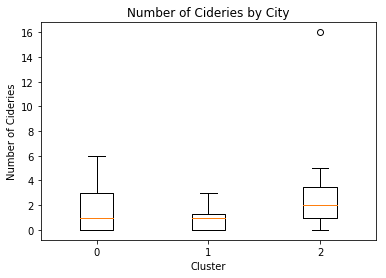

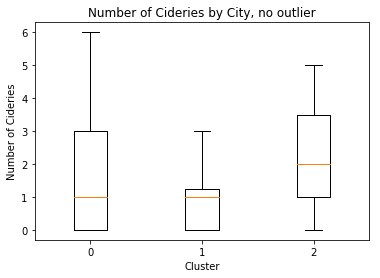

In [50]:
# make a box plot of the data 
import matplotlib.pyplot as plt

cidery_frequency = [city_cluster_0.Frequency, city_cluster_1.Frequency, city_cluster_2.Frequency]
plt.boxplot(cidery_frequency)
plt.xticks([1, 2, 3], ['0', '1', '2'])
plt.xlabel('Cluster')
plt.ylabel('Number of Cideries')
plt.title('Number of Cideries by City')
plt.show()

# without outlier 

plt.boxplot(cidery_frequency, showfliers=False)
plt.xticks([1, 2, 3], ['0', '1', '2'])
plt.xlabel('Cluster')
plt.ylabel('Number of Cideries')
plt.title('Number of Cideries by City, no outlier')
plt.show()

Based on the boxplots above, Cluster 0 and Cluster 2 both look like strong candidates to focus on. Cluster 2 has a major outlier: one of its cities has 16 cideries (Portland, Oregon -- unsurprisingly). In addition to considering the mean number of cideries in each city, this means I should also consider the median and the percent of cities in each cluster with cideries. These summary statistics will not be as influenced by the presence of this outlier.

In [44]:
# Get summary stats of each cluster

def cidery_stats(df):
    """ Calculte total number of cideries, mean number of cideries, median number of cideries
            and percent of cities with at least one cidery in it """
    # get number of cideries per city 
    cideries_no = df.Frequency.sum()
    
    # get cideries per city
    mean_cideries = df.Frequency.mean()
    
    # median cideries
    median_cideries = df.Frequency.median()
    
    # get percent of cities with cidery 
    cities_with_cideries = 0 
    for i in df.Frequency:
        if i > 0:
            cities_with_cideries += 1 
            
    cideries_pct = cities_with_cideries / len(df.Frequency)
    
    return [cideries_no, mean_cideries, median_cideries, cideries_pct]


a = cidery_stats(city_cluster_0)
b = cidery_stats(city_cluster_1)
c = cidery_stats(city_cluster_2)

In [45]:
summary_stats = pd.DataFrame({'Cluster 0': a, 'Cluster 1': b, 'Cluster 2': c})

summary_stats = summary_stats.transpose()
summary_stats.columns = ['total_cideries', 'mean_cideries', 'median_cideries', 
                        'cidery_city_pct']

summary_stats

,total_cideries,mean_cideries,median_cideries,cidery_city_pct
Cluster 0,8.0,2.000000,1.0,0.500000
Cluster 1,25.0,0.892857,1.0,0.535714
Cluster 2,45.0,3.000000,2.0,0.800000


It looks like Cluster 2 is the best option here -- it has the highest mean and median number of cideries, and 80% of the cities found in this cluster have at least one cidery, as compared to ~50% of cities in both of the other two clusters. 


### ANOVA and Tukey's Test

Now I want to use one-way ANOVA and Tukey's test to see if this difference is significant. Here, my null hypothesis is that cidery distribution is equal across all clusters, so the mean number of cideries in each cluster would be the same:

$H_0$ : $\mu_{cluster 0}$ = $\mu_{cluster 1}$ = $\mu_{cluster 2}$

Here, we will be using a significance value of $\alpha = 0.05$, or a 95% confidence interval. To reject the null hypothesis, we need to see $p \leq 0.05$ in the one-way ANOVA test.

In [52]:
import numpy as np 
from scipy import stats

# One-way ANOVA

f, p = stats.f_oneway(city_cluster_0.Frequency, city_cluster_1.Frequency, 
                      city_cluster_2.Frequency)


print('One-way ANOVA')
print('----------------')
print('F value:', f)
print('P value', p)

One-way ANOVA
----------------
F value: 3.59255163598
P value 0.0358756714177


With a $p$-value of 0.036, we can reject the null hypothesis with 95% confidence. However, all this tells us is that there is a statistically significant difference between the mean number of cideries in each cluster, but we do not know which cluster is the best or worst (even though we may have an idea from the summary statistics). 

Tukey's range test will tell us if Cluster 2 really does have a statistically significant difference in cidery prevelance than the other two clusters. 

In [59]:
# Tukey test 

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

# combine three dataframes into one
data = pd.concat([city_cluster_0, city_cluster_1, city_cluster_2])

mc = MultiComparison(data.Frequency, data.log_labels)
result = mc.tukeyhsd()

print(result)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 0.0    1.0   -1.1071  -4.3108 2.0965 False 
 0.0    2.0     1.0    -2.3727 4.3727 False 
 1.0    2.0    2.1071   0.1894 4.0249  True 
--------------------------------------------


The Tukey test tells us that there is a statistically significant difference in the mean number of cideries in Cluster 2 and Cluster 1. Now we are left with Cluster 0 and Cluster 2 with a high prevalence of cideries in terms of the mean number of cideries. However, I am also interested in the representation of cideries across cities in each of these clusters: in other words, I am not just interested in the mean number of cideries in these clusters, but also the percent of cities in each cluster that have at least one or more cideries. This could tell us if the demographic features of one of these clusters creates a stronger market for the craft cider scene. 

### Permutation Sampling

Based on the summary statistics, I believe that Cluster 2 is a stronger cluster for the craft cider market: we see 80% of cities with at least one cidery, whereas Cluster 0 has at least on cidery in only 50% of the cities. But is this difference statistically significant? Let's do some permutation sampling to see if this difference in cidery prevelance is significantly different than if the cities were randomly distributed between these two clusters. 

In [93]:
# create a permutation sample 
def permutation_sample(data1, data2):
    
    # concatenate the dataframes 
    data = np.concatenate((data1, data2))
    
    # permute the data 
    permuted_data = np.random.permutation(data)
    
    # split into two random dataframes 
    permuted_sample1 = permuted_data[:len(data1)]
    permuted_sample2 = permuted_data[len(data1):]
    
    return permuted_sample1, permuted_sample2

# generate multiple permutation replicates 
def draw_perm_reps(data1, data2, func, size=1):
    
    # initialize an empty array
    perm_reps = np.empty(size)
    
    for i in range(size):
        
        # generate permutation samples
        perm_sample1, perm_sample2 = permutation_sample(data1, data2)

        # compute test statistic 
        perm_reps[i] = func(perm_sample1, perm_sample2)
        
        return perm_reps
    
# create the function of interest: difference in % of cities with one or more cideries 

def diff_of_pct(data1, data2):
    data1_pct = np.sum(data1 > 0) / len(data1)
    
    data2_pct = np.sum(data2 > 0) / len(data2)
    
    return data1_pct - data2_pct 
    

In [95]:
# compute the observed difference of % of cities with cideries between the two clusters 

empirical_diff_pct = diff_of_pct(city_cluster_2.Frequency, city_cluster_0.Frequency)

0.3


In the data, we see a 30% difference between the percent of cities in Cluster 2 with at least one cidery and the percent of cities in Cluster 0 with at least one cidery. Next, we will test the probability that this difference in cidery prevalance occurred by chance using permutation replicate samples of the data. 

In [108]:
# draw 10,000 permutation replicates 

permutation_replicates = draw_perm_reps(city_cluster_2.Frequency, city_cluster_0.Frequency,
                                        diff_of_pct, size=10000)

# compute p-value

p = np.sum(permutation_replicates >= empirical_diff_pct) / len(permutation_replicates)

print("P-value:", p)

P-value: 0.0001


With a p-value of 0.0001, we see that the probability of seeing a 30% or greater difference in cidery prevalance between these two clusters simply by chance is extremely low. Therefore, we can reject the null hypothesis that you could see a difference in cidery prevalence this large with a random distribution of cities between these two clusters. This tells us that the it is likely demographic features that were used to create these clusters have some impact on the craft cider market. 

Moving forward, I will want to focus on Cluster 2 when making my recommendations to Sociable CiderWerks for a strong target city for a new cider taproom. 

In [110]:
print("Target Cities for new Sociable CiderWerks Taproom:")
city_cluster_2.City

Target Cities for new Sociable CiderWerks Taproom:


0         Long Beach city
1        Los Angeles city
2            Oakland city
3          San Diego city
4             Denver city
5            Atlanta city
6            Chicago city
7             Boston city
8        Minneapolis city
9           New York city
10         Charlotte city
11           Raleigh city
12          Portland city
13            Austin city
14    Virginia Beach city
Name: City, dtype: object

### Conclusion 

Cluster analysis and inferential statistics have helped narrow down a long list of potential cities to just fifteen strong candidate cities for a new taproom. So far, I have mainly been focusing on differences between clusters. Now, I will need to explore differences between the cities in Cluster 2 to narrow this list down to just a few recommendations for Sociable CiderWerks. 